# Deeper MLP would improve its performance

In [1]:
# Import general libraries here.
import os
import glob
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [2]:
# Directory names.
DATA_DIR = "D:\\Programming\\20220712_titanic\\kaggle-titanic\\data\\titanic"
SRC_DIR = "D:\\Programming\\20220712_titanic\\kaggle-titanic\\src"
RESULT_DIR = "D:\\Programming\\20220712_titanic\\kaggle-titanic\\result\\20220713_nb02"
os.makedirs(RESULT_DIR, exist_ok=True)

## Load titanic data

In [3]:
train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Define 5-layer MLP

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.fc1 = nn.Linear(self.in_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, out_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        x = torch.sigmoid(x)
        return x

In [6]:
#print(torch.cuda.is_available())
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#test_in = torch.zeros((1, 5)).to("cuda:0")
#model = Net(5, 1).cuda()
#test_out = model(test_in)
#print(test_out)

## Trainer

In [7]:
# Definition of dataset.

from torch.utils.data import Dataset, DataLoader

class TitanicDataset(Dataset):
    def __init__(self, data_df, train):
        self.data_df = data_df
        self.train = train
        self.features = ["Pclass", "Sex", "SibSp", "Parch"]
        if self.train:
            self.labels = self.data_df["Survived"].values
        self.inputs = pd.get_dummies(self.data_df[self.features]).values
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        in_feat = self.inputs[idx]
        in_feat = torch.from_numpy(in_feat).float()
        if self.train:
            label = self.labels[idx]
            #label = torch.from_numpy(label)
            label = torch.tensor(label).float()
            return in_feat, label
        return in_feat

In [8]:
# Setup training environments.

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 100
learning_rate = 1e-3
average_loss_list = list()

# Dataloaders.
train_dataset = TitanicDataset(train_data, train=True)
test_dataset = TitanicDataset(test_data, train=False)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Model definition.
model = Net(5, 1).to(device)
#model = Net(5, 1)
model = model.train()

# Optimizer / Loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction="mean")

for epoch in range(n_epochs):
    loss_sum = 0
    for in_feat, label in tqdm(train_loader):
        in_feat = in_feat.to(device)
        label = label.to(device)
        #print(in_feat)
        #print(label)

        optimizer.zero_grad()

        output = model(in_feat)
        output = output[:, 0]
        loss = criterion(output, label)
        loss_sum += loss.item()

        loss.backward()
        optimizer.step()
    average_loss_list.append(loss_sum / len(train_loader))
    print(f"Epoch : {epoch} / {n_epochs} | Loss average : {loss_sum / len(train_loader)}")
    torch.save(model.state_dict(), os.path.join(RESULT_DIR, "model-best.pt"))

#loss_sum = 0
predictions = list()
with torch.no_grad():
    for in_feat in tqdm(test_loader):
        in_feat = in_feat.to(device)
        output = model(in_feat)
        output = output[:, 0]
        prediction = torch.where(output >= 0.5, 1, 0).detach().cpu().numpy()
        predictions.extend(prediction)

output = pd.DataFrame({
    "PassengerId": test_data.PassengerId,
    "Survived": predictions
})
output_file = os.path.join(RESULT_DIR, "submission.csv")
output.to_csv(output_file, index=False)
print(f"Saved submission csv file as: {output_file}")

100%|██████████| 18/18 [00:01<00:00, 11.49it/s]


Epoch : 0 / 100 | Loss average : 0.6333708663781484


100%|██████████| 18/18 [00:00<00:00, 272.74it/s]


Epoch : 1 / 100 | Loss average : 0.5377481596337425


100%|██████████| 18/18 [00:00<00:00, 290.32it/s]


Epoch : 2 / 100 | Loss average : 0.49084974494245315


100%|██████████| 18/18 [00:00<00:00, 285.07it/s]


Epoch : 3 / 100 | Loss average : 0.49004528092013466


100%|██████████| 18/18 [00:00<00:00, 289.28it/s]


Epoch : 4 / 100 | Loss average : 0.4787195838159985


100%|██████████| 18/18 [00:00<00:00, 276.93it/s]


Epoch : 5 / 100 | Loss average : 0.4563016924593184


100%|██████████| 18/18 [00:00<00:00, 253.53it/s]


Epoch : 6 / 100 | Loss average : 0.4458949300977919


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 7 / 100 | Loss average : 0.44620522525575423


100%|██████████| 18/18 [00:00<00:00, 238.64it/s]


Epoch : 8 / 100 | Loss average : 0.4405595345629586


100%|██████████| 18/18 [00:00<00:00, 268.67it/s]


Epoch : 9 / 100 | Loss average : 0.43648210333453286


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 10 / 100 | Loss average : 0.43468596041202545


100%|██████████| 18/18 [00:00<00:00, 267.33it/s]


Epoch : 11 / 100 | Loss average : 0.43621427814165753


100%|██████████| 18/18 [00:00<00:00, 240.01it/s]


Epoch : 12 / 100 | Loss average : 0.42936527397897506


100%|██████████| 18/18 [00:00<00:00, 276.93it/s]


Epoch : 13 / 100 | Loss average : 0.4377477334605323


100%|██████████| 18/18 [00:00<00:00, 287.03it/s]


Epoch : 14 / 100 | Loss average : 0.4427639726135466


100%|██████████| 18/18 [00:00<00:00, 253.53it/s]


Epoch : 15 / 100 | Loss average : 0.43815764950381386


100%|██████████| 18/18 [00:00<00:00, 321.44it/s]


Epoch : 16 / 100 | Loss average : 0.43442347480191124


100%|██████████| 18/18 [00:00<00:00, 248.19it/s]


Epoch : 17 / 100 | Loss average : 0.42862700257036424


100%|██████████| 18/18 [00:00<00:00, 258.95it/s]


Epoch : 18 / 100 | Loss average : 0.43195700893799466


100%|██████████| 18/18 [00:00<00:00, 260.88it/s]


Epoch : 19 / 100 | Loss average : 0.43201714091830784


100%|██████████| 18/18 [00:00<00:00, 268.66it/s]


Epoch : 20 / 100 | Loss average : 0.43021272122859955


100%|██████████| 18/18 [00:00<00:00, 281.26it/s]


Epoch : 21 / 100 | Loss average : 0.42867690490351784


100%|██████████| 18/18 [00:00<00:00, 235.90it/s]


Epoch : 22 / 100 | Loss average : 0.42709334360228646


100%|██████████| 18/18 [00:00<00:00, 290.34it/s]


Epoch : 23 / 100 | Loss average : 0.42364011373784805


100%|██████████| 18/18 [00:00<00:00, 375.02it/s]


Epoch : 24 / 100 | Loss average : 0.42806052168210346


100%|██████████| 18/18 [00:00<00:00, 257.15it/s]


Epoch : 25 / 100 | Loss average : 0.4227247503068712


100%|██████████| 18/18 [00:00<00:00, 227.85it/s]


Epoch : 26 / 100 | Loss average : 0.424961076842414


100%|██████████| 18/18 [00:00<00:00, 290.33it/s]


Epoch : 27 / 100 | Loss average : 0.4238395757145352


100%|██████████| 18/18 [00:00<00:00, 274.22it/s]


Epoch : 28 / 100 | Loss average : 0.42773855560355717


100%|██████████| 18/18 [00:00<00:00, 268.66it/s]


Epoch : 29 / 100 | Loss average : 0.43657971587446


100%|██████████| 18/18 [00:00<00:00, 268.67it/s]


Epoch : 30 / 100 | Loss average : 0.42724838852882385


100%|██████████| 18/18 [00:00<00:00, 290.33it/s]


Epoch : 31 / 100 | Loss average : 0.4222574796941545


100%|██████████| 18/18 [00:00<00:00, 257.15it/s]


Epoch : 32 / 100 | Loss average : 0.422490946120686


100%|██████████| 18/18 [00:00<00:00, 276.92it/s]


Epoch : 33 / 100 | Loss average : 0.42793263329399955


100%|██████████| 18/18 [00:00<00:00, 238.56it/s]


Epoch : 34 / 100 | Loss average : 0.4294505152437422


100%|██████████| 18/18 [00:00<00:00, 237.52it/s]


Epoch : 35 / 100 | Loss average : 0.4279741876655155


100%|██████████| 18/18 [00:00<00:00, 263.44it/s]


Epoch : 36 / 100 | Loss average : 0.42378638519181144


100%|██████████| 18/18 [00:00<00:00, 300.01it/s]


Epoch : 37 / 100 | Loss average : 0.42306983636485207


100%|██████████| 18/18 [00:00<00:00, 260.01it/s]


Epoch : 38 / 100 | Loss average : 0.42529359625445473


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 39 / 100 | Loss average : 0.42011464801099563


100%|██████████| 18/18 [00:00<00:00, 268.66it/s]


Epoch : 40 / 100 | Loss average : 0.4192887726757262


100%|██████████| 18/18 [00:00<00:00, 264.71it/s]


Epoch : 41 / 100 | Loss average : 0.4186451617214415


100%|██████████| 18/18 [00:00<00:00, 304.15it/s]


Epoch : 42 / 100 | Loss average : 0.4186699373854531


100%|██████████| 18/18 [00:00<00:00, 294.84it/s]


Epoch : 43 / 100 | Loss average : 0.4201957666211658


100%|██████████| 18/18 [00:00<00:00, 281.25it/s]


Epoch : 44 / 100 | Loss average : 0.41801102459430695


100%|██████████| 18/18 [00:00<00:00, 304.05it/s]


Epoch : 45 / 100 | Loss average : 0.4193030562665727


100%|██████████| 18/18 [00:00<00:00, 243.25it/s]


Epoch : 46 / 100 | Loss average : 0.41720426248179543


100%|██████████| 18/18 [00:00<00:00, 264.70it/s]


Epoch : 47 / 100 | Loss average : 0.41759832865662044


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 48 / 100 | Loss average : 0.42021256188551587


100%|██████████| 18/18 [00:00<00:00, 250.75it/s]


Epoch : 49 / 100 | Loss average : 0.4263117081589169


100%|██████████| 18/18 [00:00<00:00, 295.08it/s]


Epoch : 50 / 100 | Loss average : 0.4177432391378615


100%|██████████| 18/18 [00:00<00:00, 257.15it/s]


Epoch : 51 / 100 | Loss average : 0.41635167929861283


100%|██████████| 18/18 [00:00<00:00, 264.71it/s]


Epoch : 52 / 100 | Loss average : 0.4157007551855511


100%|██████████| 18/18 [00:00<00:00, 290.33it/s]


Epoch : 53 / 100 | Loss average : 0.41604941752221847


100%|██████████| 18/18 [00:00<00:00, 305.09it/s]


Epoch : 54 / 100 | Loss average : 0.4168853958447774


100%|██████████| 18/18 [00:00<00:00, 257.15it/s]


Epoch : 55 / 100 | Loss average : 0.4172125789854262


100%|██████████| 18/18 [00:00<00:00, 295.10it/s]


Epoch : 56 / 100 | Loss average : 0.4138355520036485


100%|██████████| 18/18 [00:00<00:00, 282.51it/s]


Epoch : 57 / 100 | Loss average : 0.42098382529285217


100%|██████████| 18/18 [00:00<00:00, 305.09it/s]


Epoch : 58 / 100 | Loss average : 0.4199954718351364


100%|██████████| 18/18 [00:00<00:00, 456.27it/s]


Epoch : 59 / 100 | Loss average : 0.41677964230378467


100%|██████████| 18/18 [00:00<00:00, 276.93it/s]


Epoch : 60 / 100 | Loss average : 0.41512179209126365


100%|██████████| 18/18 [00:00<00:00, 281.26it/s]


Epoch : 61 / 100 | Loss average : 0.4139581976665391


100%|██████████| 18/18 [00:00<00:00, 305.09it/s]


Epoch : 62 / 100 | Loss average : 0.41400032573276097


100%|██████████| 18/18 [00:00<00:00, 295.08it/s]


Epoch : 63 / 100 | Loss average : 0.41577761206361985


100%|██████████| 18/18 [00:00<00:00, 264.71it/s]


Epoch : 64 / 100 | Loss average : 0.4170212546984355


100%|██████████| 18/18 [00:00<00:00, 257.15it/s]


Epoch : 65 / 100 | Loss average : 0.41762249834007686


100%|██████████| 18/18 [00:00<00:00, 250.12it/s]


Epoch : 66 / 100 | Loss average : 0.4146774179405636


100%|██████████| 18/18 [00:00<00:00, 268.66it/s]


Epoch : 67 / 100 | Loss average : 0.41137893663512337


100%|██████████| 18/18 [00:00<00:00, 265.29it/s]


Epoch : 68 / 100 | Loss average : 0.41580068568388623


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 69 / 100 | Loss average : 0.4116385628779729


100%|██████████| 18/18 [00:00<00:00, 300.00it/s]


Epoch : 70 / 100 | Loss average : 0.4159443610244327


100%|██████████| 18/18 [00:00<00:00, 310.34it/s]


Epoch : 71 / 100 | Loss average : 0.4140886565049489


100%|██████████| 18/18 [00:00<00:00, 253.53it/s]


Epoch : 72 / 100 | Loss average : 0.4133956945604748


100%|██████████| 18/18 [00:00<00:00, 301.32it/s]


Epoch : 73 / 100 | Loss average : 0.41320862538284725


100%|██████████| 18/18 [00:00<00:00, 315.80it/s]


Epoch : 74 / 100 | Loss average : 0.4124520851506127


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 75 / 100 | Loss average : 0.41494715213775635


100%|██████████| 18/18 [00:00<00:00, 269.66it/s]


Epoch : 76 / 100 | Loss average : 0.41587476432323456


100%|██████████| 18/18 [00:00<00:00, 230.77it/s]


Epoch : 77 / 100 | Loss average : 0.41196588344044155


100%|██████████| 18/18 [00:00<00:00, 227.85it/s]


Epoch : 78 / 100 | Loss average : 0.41288387609852684


100%|██████████| 18/18 [00:00<00:00, 260.87it/s]


Epoch : 79 / 100 | Loss average : 0.41816981385151547


100%|██████████| 18/18 [00:00<00:00, 268.67it/s]


Epoch : 80 / 100 | Loss average : 0.41403964989715153


100%|██████████| 18/18 [00:00<00:00, 283.97it/s]


Epoch : 81 / 100 | Loss average : 0.41100574533144635


100%|██████████| 18/18 [00:00<00:00, 268.67it/s]


Epoch : 82 / 100 | Loss average : 0.40843553178840214


100%|██████████| 18/18 [00:00<00:00, 246.58it/s]


Epoch : 83 / 100 | Loss average : 0.4070829136504067


100%|██████████| 18/18 [00:00<00:00, 285.63it/s]


Epoch : 84 / 100 | Loss average : 0.40734413431750405


100%|██████████| 18/18 [00:00<00:00, 230.77it/s]


Epoch : 85 / 100 | Loss average : 0.4077577872408761


100%|██████████| 18/18 [00:00<00:00, 283.03it/s]


Epoch : 86 / 100 | Loss average : 0.4097222089767456


100%|██████████| 18/18 [00:00<00:00, 257.15it/s]


Epoch : 87 / 100 | Loss average : 0.410943071047465


100%|██████████| 18/18 [00:00<00:00, 276.93it/s]


Epoch : 88 / 100 | Loss average : 0.41137418813175625


100%|██████████| 18/18 [00:00<00:00, 281.26it/s]


Epoch : 89 / 100 | Loss average : 0.40932267407576245


100%|██████████| 18/18 [00:00<00:00, 268.66it/s]


Epoch : 90 / 100 | Loss average : 0.40877653575605816


100%|██████████| 18/18 [00:00<00:00, 280.10it/s]


Epoch : 91 / 100 | Loss average : 0.40797118180327946


100%|██████████| 18/18 [00:00<00:00, 250.01it/s]


Epoch : 92 / 100 | Loss average : 0.40773921542697483


100%|██████████| 18/18 [00:00<00:00, 293.27it/s]


Epoch : 93 / 100 | Loss average : 0.40592315627468956


100%|██████████| 18/18 [00:00<00:00, 276.93it/s]


Epoch : 94 / 100 | Loss average : 0.4105670866039064


100%|██████████| 18/18 [00:00<00:00, 268.67it/s]


Epoch : 95 / 100 | Loss average : 0.40872274670335984


100%|██████████| 18/18 [00:00<00:00, 252.42it/s]


Epoch : 96 / 100 | Loss average : 0.40649199816915726


100%|██████████| 18/18 [00:00<00:00, 261.08it/s]


Epoch : 97 / 100 | Loss average : 0.40989991029103595


100%|██████████| 18/18 [00:00<00:00, 253.53it/s]


Epoch : 98 / 100 | Loss average : 0.4072590188847648


100%|██████████| 18/18 [00:00<00:00, 240.00it/s]


Epoch : 99 / 100 | Loss average : 0.40877387258741593


100%|██████████| 9/9 [00:00<00:00, 900.04it/s]

Saved submission csv file as: D:\Programming\20220712_titanic\kaggle-titanic\result\20220713_nb02\submission.csv


## Plot loss curve

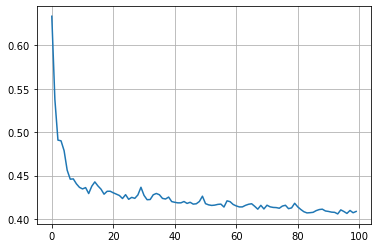

In [9]:
# Following code required for plotting figure in jupyter notebook.
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(average_loss_list)
plt.grid()
plt.show()